In [64]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os
from new_MLP import MLP

%matplotlib inline

In [65]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [66]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [67]:
def scaling_output(output_30, target_place):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp
    output_30 = output_30.drop(['year'], axis=1)
    return output_30

In [68]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))

In [69]:
ukisima = output_30[['datetime', 'SOLA01']]
ougishima = output_30[['datetime', 'SOLA02']]
ukisima = scaling_output(ukisima, 1)["SOLA01"]
ougishima = scaling_output(ougishima, 2)["SOLA02"]

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [73]:
ratio = np.array((ougishima / ukisima))

In [74]:
ratio

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [79]:
ratio = ratio[np.where(ratio > 0)]

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [80]:
ratio = ratio[np.where(ratio < 10)]

(array([  3.23000000e+02,   1.07000000e+03,   3.19600000e+03,
          9.23400000e+03,   1.43820000e+04,   1.99000000e+03,
          6.29000000e+02,   3.13000000e+02,   1.81000000e+02,
          1.08000000e+02,   8.60000000e+01,   5.40000000e+01,
          4.30000000e+01,   6.20000000e+01,   3.70000000e+01,
          3.50000000e+01,   1.50000000e+01,   2.30000000e+01,
          2.60000000e+01,   1.50000000e+01,   1.70000000e+01,
          5.00000000e+00,   1.60000000e+01,   1.00000000e+01,
          5.00000000e+00,   6.00000000e+00,   1.30000000e+01,
          1.90000000e+01,   0.00000000e+00,   1.00000000e+00]),
 array([ 0.01302912,  0.33451581,  0.6560025 ,  0.97748919,  1.29897588,
         1.62046257,  1.94194926,  2.26343595,  2.58492264,  2.90640933,
         3.22789602,  3.54938271,  3.8708694 ,  4.19235608,  4.51384277,
         4.83532946,  5.15681615,  5.47830284,  5.79978953,  6.12127622,
         6.44276291,  6.7642496 ,  7.08573629,  7.40722298,  7.72870967,
         8.05

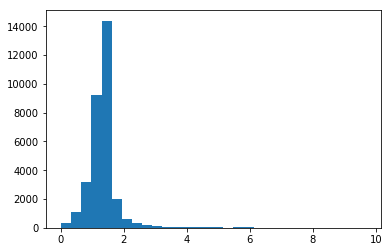

In [82]:
plt.hist(ratio, bins=30)

In [85]:
# いろんなモデルの予測値の集合(学習用)
train_prediction1 = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(1)+".tsv", delimiter="\t")
train_prediction1['datetime'] = train_prediction1['datetime'].map(lambda x : pd.to_datetime(x))

In [86]:
# いろんなモデルの予測値の集合(学習用)
train_prediction2 = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(2)+".tsv", delimiter="\t")
train_prediction2['datetime'] = train_prediction2['datetime'].map(lambda x : pd.to_datetime(x))

In [87]:
pred_ukishima = train_prediction1.drop(["datetime"], axis=1).mean(axis = 1)
pred_ougishima = train_prediction2.drop(["datetime"], axis=1).mean(axis = 1)

In [90]:
len(ougishima[48:]), len(pred_ukishima)

(70080, 70080)

In [91]:
np.array(ougishima[48:])

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [96]:
tmp = np.array(ougishima[48:]) - np.array(pred_ougishima)

In [104]:
tmp_df = pd.DataFrame(ougishima[48:])
tmp_df.index = np.arange(len(tmp_df))

In [106]:
tmp_df["pred"] = pred_ougishima

In [109]:
tmp_df["diff"] = tmp_df["SOLA02"] - tmp_df["pred"]

In [112]:
# pred_ougishima のmae
abs(tmp_df["diff"]).mean()

227.19392254718201

In [157]:
tmp_df["pred"] = pred_ukishima*1.40

In [158]:
tmp_df["diff"] = tmp_df["SOLA02"] - tmp_df["pred"]

In [159]:
# pred_ukishimaのmae
abs(tmp_df["diff"]).mean()

230.88463610814935